### Visualizing Nebraska Dataset Labels

In [1]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
nebraska_labels = gpd.read_file("/mnt/cropmaskperm/external/nebraska_pivots_projected.geojson")

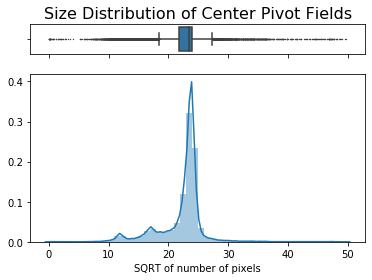

In [2]:
import seaborn as sns
import numpy as np
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(np.sqrt(nebraska_labels['AREA'] / (30**2*3.28084**2)), ax=ax_box, fliersize=.5)
sns.distplot(np.sqrt(nebraska_labels['AREA'] / (30**2*3.28084**2)), ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title("Size Distribution of Center Pivot Fields",fontsize=16)
ax_hist.set(xlabel='SQRT of number of pixels')
plt.savefig("./size_distribution.png")

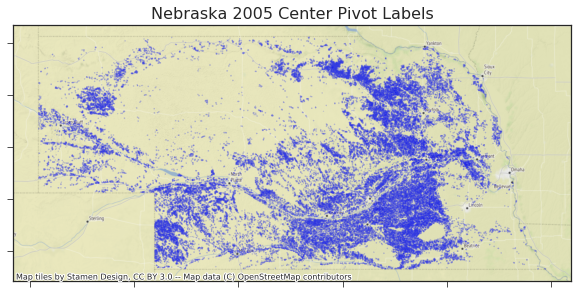

In [3]:
plt.style.use("seaborn-ticks")
ax = nebraska_labels.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.2, edgecolor='b')
ctx.add_basemap(ax)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("Nebraska 2005 Center Pivot Labels", fontsize= 16)
plt.savefig("./nebraska_cp_map.png")

In [4]:
np.sqrt(nebraska_labels['AREA'] / (30**2*3.28084**2))

0        24.032084
1        24.334756
2        24.059180
3        22.074858
4        23.999821
           ...    
52122    24.855373
52123    24.169060
52124    18.576509
52125    17.031984
52126    25.863367
Name: AREA, Length: 52127, dtype: float64

In [5]:
center_pivot_diameter_ft = np.sqrt(nebraska_labels['AREA']/np.pi)*2
cp_diameter_pixels = (center_pivot_diameter_ft / 3.28084) / 30

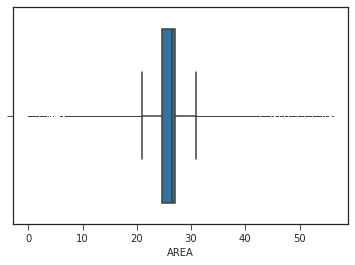

In [6]:
import numpy as np

sns.boxplot(cp_diameter_pixels, fliersize=.3)

In [7]:
(np.sqrt(nebraska_labels['AREA'] / (30**2*3.28084**2))).quantile([0.25,0.5,0.75])

0.25    21.805885
0.50    23.400393
0.75    24.016960
Name: AREA, dtype: float64

### Visualizing Detections

In [8]:
import argparse
import os
from itertools import chain
import cv2
import skimage.io as skio
import tqdm
import json
from collections import defaultdict
from fvcore.common.file_io import PathManager
import numpy as np
import yaml

import pycocotools.mask as mask_util
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Boxes, BoxMode, Instances
from pathlib import Path
from detectron2.data.datasets import register_coco_instances
from detectron2 import evaluation
from detectron2.utils.visualizer import ColorMode
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

In [9]:
experiment_dir = "/datadrive/cropmask_experiments/rgb-jpeg-split-geo-nebraska-freeze0-withseed/"
cfg_path = os.path.join(experiment_dir, "config.yaml")
cfg = get_cfg()    # obtain detectron2's default config
cfg.CONFIG_NAME = '' # add new configs for your own custom components
cfg.DATASET_PATH = ''
cfg.merge_from_file(cfg_path)   # load values from a file
tiles_path = Path(cfg.DATASET_PATH) / "tiles"
coco_path = Path(cfg.DATASET_PATH) / "coco"
train_coco_instances_path = str(coco_path / "det_instances_train.json")
val_coco_instances_path = str(coco_path / "det_instances_val.json")
test_coco_instances_path = str(coco_path / "det_instances_test.json")
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
register_coco_instances(cfg.DATASETS.TRAIN[0], {"thing_colors":[[148,0,211]]}, train_coco_instances_path, str(next(tiles_path.glob("*jpeg*"))))
register_coco_instances("validation", {"thing_colors":[[148,0,211]]}, val_coco_instances_path, str(next(tiles_path.glob("*jpeg*")))) # changed to val from test
register_coco_instances("test", {"thing_colors":[[148,0,211]]}, test_coco_instances_path, str(next(tiles_path.glob("*jpeg*"))))
model_path = os.path.join(experiment_dir, "model_0002799.pth")
predictions_path = os.path.join(experiment_dir, "inference/coco_instances_results.json")
test_pred_dir = os.path.join(experiment_dir, "inference/test_predictions")
val_pred_dir = os.path.join(experiment_dir, "inference/val_predictions")
outpredfig_dir = os.path.join(test_pred_dir, "inference/figs") # experiment dir for val set
test_predictions_path = os.path.join(test_pred_dir, "coco_instances_results.json")

### Predicting on the test set and saving results in json format alongside coco_instances_results.josn, which is for the validation set.

In [10]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
model = build_model(cfg) 
DetectionCheckpointer(model).load(model_path) 
test_loader = build_detection_test_loader(cfg, "validation")
# coco_evaluation edited to correct area ranges for dataset.
results = evaluation.inference_on_dataset(model, test_loader, DatasetEvaluators([COCOEvaluator("validation", cfg, distributed=False, output_dir = val_pred_dir)]))

Loading and preparing results...
DONE (t=0.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=37.75s).
Accumulating evaluation results...
DONE (t=1.85s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 50 ] = 0.788
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 50 ] = 0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets= 50 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 50 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 50 ] = 0.649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 25 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 50 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

## Visualizing Predictions

In [3]:
def create_instances(predictions, image_size, conf_threshold=.9):
    ret = Instances(image_size)

    allscores = np.asarray([x["score"] for x in predictions if x["score"] > .5])
    chosen = (allscores > conf_threshold).nonzero()[0]
    scores = allscores[chosen]
    bbox = np.asarray([predictions[i]["bbox"] for i in chosen]).reshape(-1, 4)
    bbox = BoxMode.convert(bbox, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)

    labels = np.asarray([dataset_id_map(predictions[i]["category_id"]) for i in chosen])

    ret.scores = scores
    ret.pred_boxes = Boxes(bbox)
    ret.pred_classes = labels
    
    try:
        ret.pred_masks = [predictions[i]["segmentation"] for i in chosen]
    except KeyError:
        pass
    return ret, allscores

with PathManager.open(test_predictions_path, "r") as f: #predictions_path for valdiation set
    predictions_json = json.load(f)

pred_by_image = defaultdict(list)
for p in predictions_json:
    pred_by_image[p["image_id"]].append(p)

dicts = list(DatasetCatalog.get("test")) # change to validation for val set
metadata = MetadataCatalog.get("test")

### Double checking that the train set and val set don't overlap

In [4]:
from detectron2.data.datasets import load_coco_json

tiles_path / "jpeg_tiles"

train_json = load_coco_json(train_coco_instances_path, (tiles_path / "jpeg_tiles"))
val_json = load_coco_json(val_coco_instances_path, (tiles_path / "jpeg_tiles"))

train_locs = [i['file_name'].split("V0_")[-1] for i in train_json]

val_locs = [i['file_name'].split("V0_")[-1] for i in val_json]

assert len(set(train_locs) - set(val_locs)) == len(set(train_locs))

## making figures with detectron2, had to customize the library's visualizer.py

100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


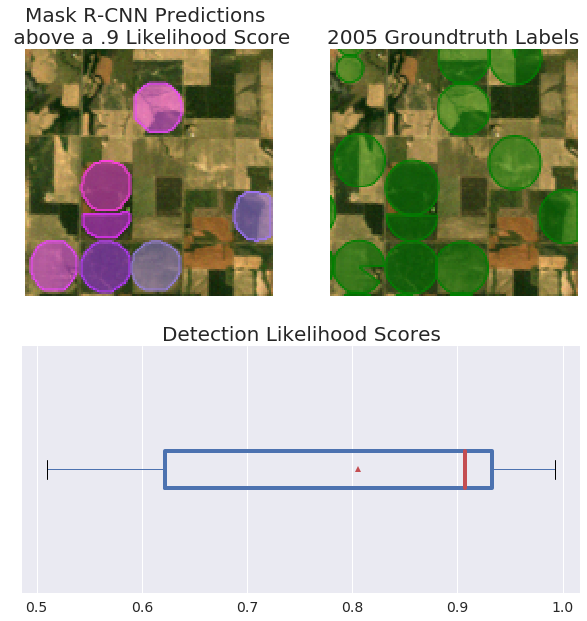

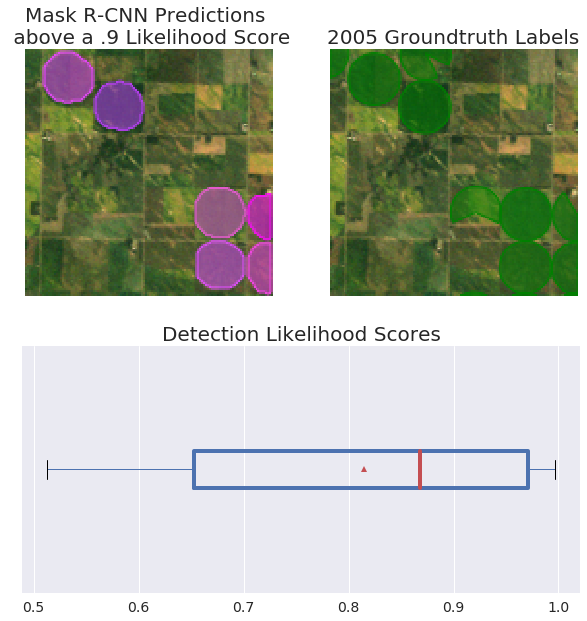

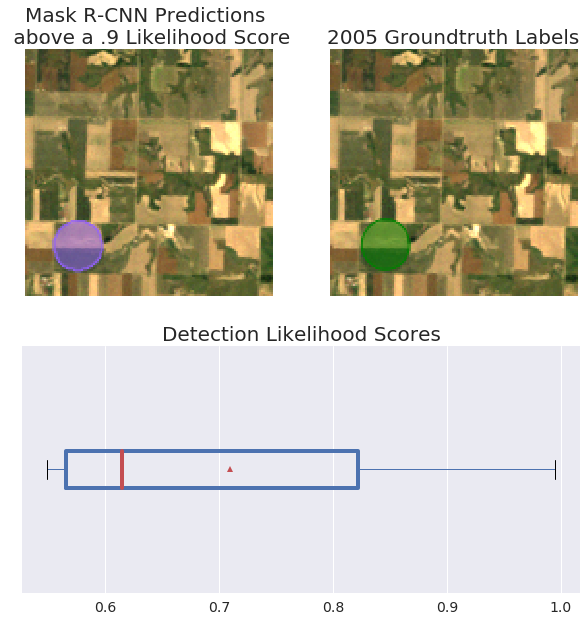

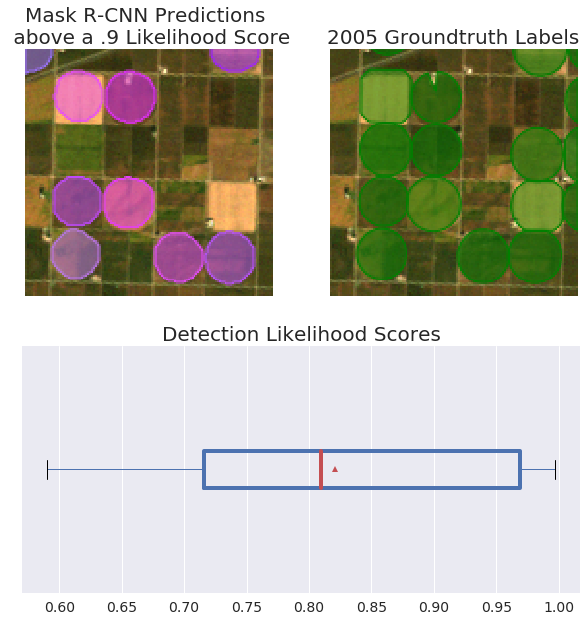

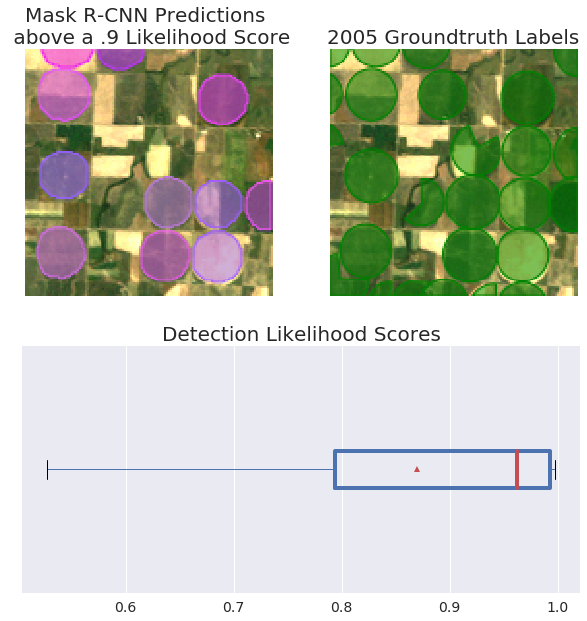

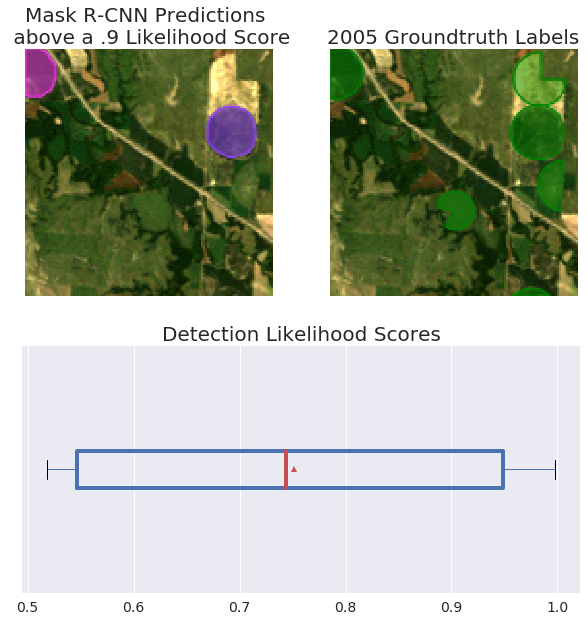

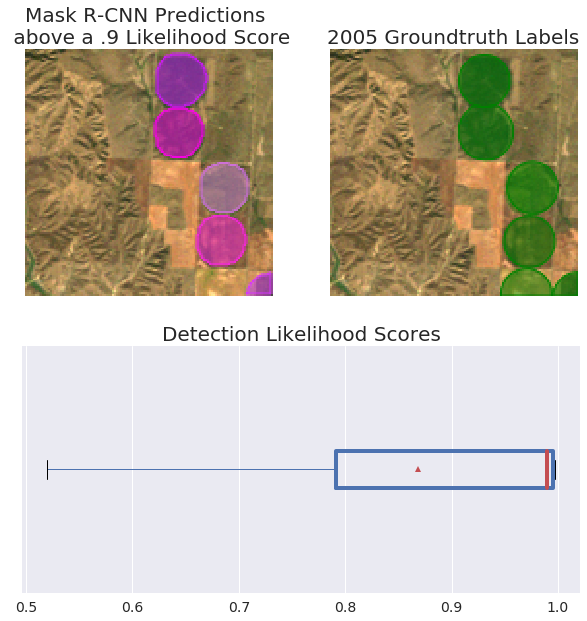

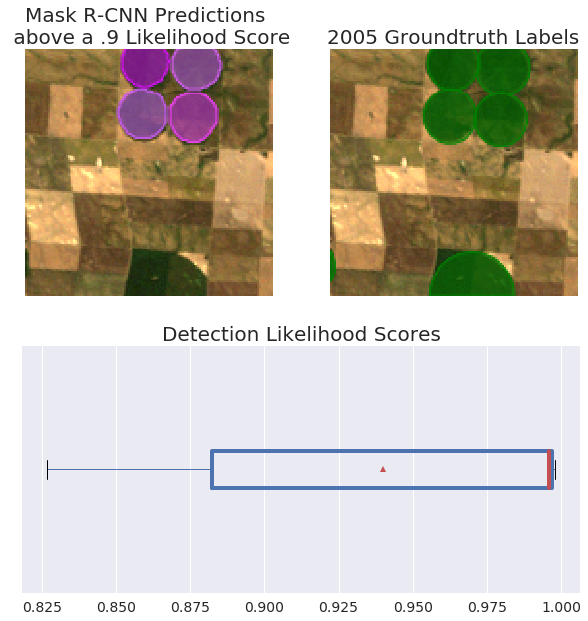

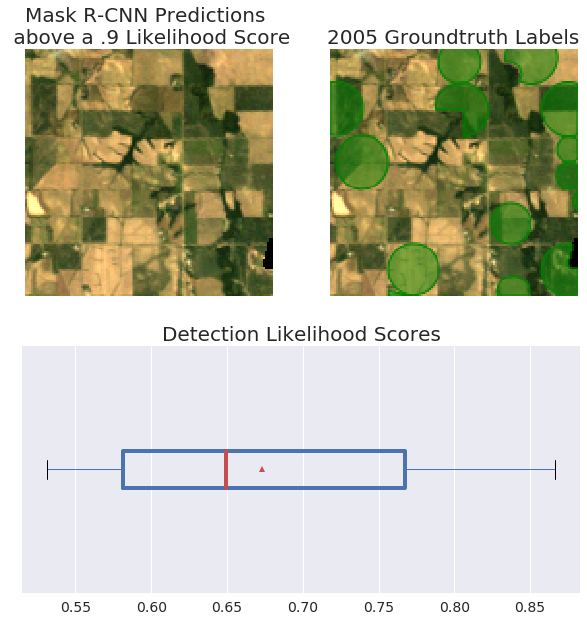

In [5]:
def dataset_id_map(ds_id):
    return metadata.thing_dataset_id_to_contiguous_id[ds_id]

def show_im(image, ax):
    # Show area outside image boundaries.
    ax.axis('off')
    ax.imshow(image)
    return ax

def plot_fig(outpath):
    gs = gridspec.GridSpec(2, 2)
    mpl.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.linewidth'] = 2
    plt.style.use("seaborn")
    fig = plt.figure(figsize=(10,10))
    ax0 = pl.subplot(gs[0,0])
    ax1 = pl.subplot(gs[0,1])
    ax2 = pl.subplot(gs[1, :])
    show_im(vis_pred_im, ax=ax0)
    ax0.set_title("Mask R-CNN Predictions \n above a .9 Likelihood Score", fontsize = 20)
    show_im(vis_g_im, ax=ax1)
    ax1.set_title("2005 Groundtruth Labels", fontsize = 20)
    scores = pd.DataFrame(all_scores, columns = ["Detection Likelihood Scores"])
    boxprops = dict(linestyle='-', linewidth=4, color='k')
    medianprops = dict(linestyle='-', linewidth=4, color='k')
    scores.boxplot(ax =ax2, vert=False, fontsize=14,  showmeans=True,
                    boxprops=boxprops,
                    medianprops=medianprops)
    y_axis = ax2.axes.get_yaxis()
    y_axis.set_visible(False)
    ax2.set_title("Detection Likelihood Scores", fontsize=20)
    plt.savefig(outpath)
    
os.makedirs(outpredfig_dir, exist_ok=True)

for dic in tqdm.tqdm(dicts[::100]):
    img = cv2.imread(dic["file_name"], cv2.IMREAD_COLOR)
    basename = os.path.basename(dic["file_name"])

    predictions, all_scores = create_instances(pred_by_image[dic["image_id"]], img.shape[:2])
    vis_p = Visualizer(img, metadata, instance_mode=ColorMode.SEGMENTATION)
    vis_pred_im = vis_p.draw_instance_predictions(predictions).get_image()

    vis_g = Visualizer(img, metadata)
    vis_g_im = vis_g.draw_dataset_dict(dic, gt=True).get_image()
    outpath = os.path.join(outpredfig_dir, "fig_"+os.path.basename(dic['file_name']))
    plot_fig(outpath)

'aoi_restricted_LT05_CU_016008_20050620_20190102_C01_V0_-88785_2076165.jpg'

# showing predictions above .9 score

In [5]:
# mask_util.decode(predictions.get_fields()['pred_masks'][0]).sum() decoding a single instance mask and counting pixels

Text(0.5, 1.0, 'Detection Likelihood Scores')

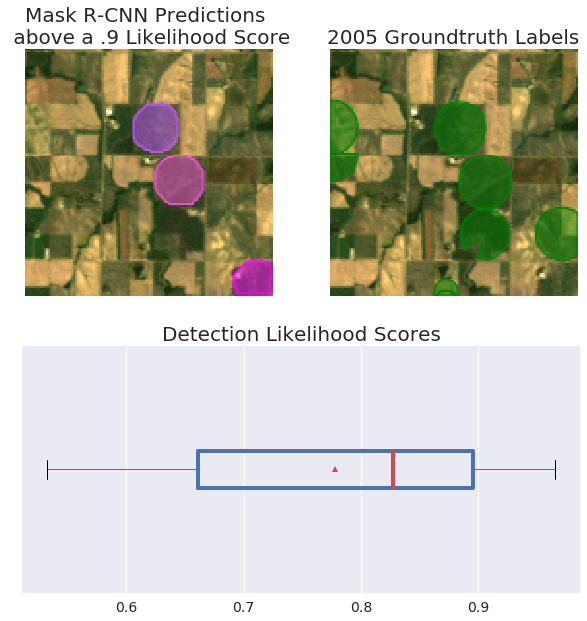

In [6]:

# Create 2x2 sub plots

def plot_fig(outpath):
    gs = gridspec.GridSpec(2, 2)
    mpl.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.linewidth'] = 2
    plt.style.use("seaborn")
    fig = plt.figure(figsize=(10,10))
    ax0 = pl.subplot(gs[0,0])
    ax1 = pl.subplot(gs[0,1])
    ax2 = pl.subplot(gs[1, :])
    show_im(vis_pred_im, ax=ax0)
    ax0.set_title("Mask R-CNN Predictions \n above a .9 Likelihood Score", fontsize = 20)
    show_im(vis_g_im, ax=ax1)
    ax1.set_title("2005 Groundtruth Labels", fontsize = 20)
    ax1.legend(["Average Precision", "Average Recall"])
    scores = pd.DataFrame(all_scores, columns = ["Detection Likelihood Scores"])
    boxprops = dict(linestyle='-', linewidth=4, color='k')
    medianprops = dict(linestyle='-', linewidth=4, color='k')
    scores.boxplot(ax =ax2, vert=False, fontsize=14,  showmeans=True,
                    boxprops=boxprops,
                    medianprops=medianprops)
    y_axis = ax2.axes.get_yaxis()
    y_axis.set_visible(False)
    ax2.set_title("Detection Likelihood Scores", fontsize=20)
    plt.savefig(outpath)


In [13]:
# mask_util.decode(mask_util.frPyObjects(dic['annotations'][0]['segmentation'], 128, 128)) decoding groundtruth mask

(128, 128, 1)

In [10]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt=COCO(val_coco_instances_path)
cocoDt=cocoGt.loadRes(predictions_path)

loading annotations into memory...
Done (t=1.30s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.37s)
creating index...
index created!


In [11]:
cocoEval = COCOeval(cocoGt,cocoDt)
cocoEval.params.areaRng = [[0 ** 2, 1e5 ** 2], [0,350], [350, 650], [650, 1e5 ** 2]]
cocoEval.params.maxDets = [10, 25, 50]

In [12]:
cocoEval.evaluate()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=42.36s).


In [13]:
cocoEval.accumulate()

Accumulating evaluation results...
DONE (t=2.01s).


In [14]:
cocoEval.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 50 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 50 ] = 0.649
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets= 50 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 50 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 50 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 25 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 50 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets= 50 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 50 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 50 ] = 0.682


In [16]:
cocoEval.eval['precision'][...,:,:]

(10, 101, 1, 4, 3)

In [46]:
dic.keys()

dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])

In [56]:
perimg_eval = cocoEval.evaluateImg(dic['image_id'], 1, [0, 1e5 ** 2], 50)

In [60]:
perimg_eval.keys()

dict_keys(['image_id', 'category_id', 'aRng', 'maxDet', 'dtIds', 'gtIds', 'dtMatches', 'gtMatches', 'dtScores', 'gtIgnore', 'dtIgnore'])

In [68]:
perimg_eval['dtIds']

[157434,
 157435,
 157436,
 157437,
 157438,
 157439,
 157440,
 157441,
 157442,
 157443,
 157444,
 157445,
 157446,
 157447,
 157448,
 157449,
 157450,
 157451,
 157452,
 157453,
 157454,
 157455,
 157456,
 157457,
 157458,
 157459,
 157460,
 157461,
 157462,
 157463,
 157464,
 157465,
 157466,
 157467,
 157468,
 157469,
 157470,
 157471,
 157472,
 157473,
 157474,
 157475,
 157476,
 157477,
 157478,
 157479,
 157480,
 157481,
 157482,
 157483]

In [27]:
predictions.get_fields()val_coco_instances_path

{'scores': array([0.96539372, 0.94077927, 0.9117496 , 0.89911556, 0.88397175,
        0.85214019, 0.83402228, 0.82156938]),
 'pred_boxes': Boxes(tensor([[5.5399e+01, 2.9516e+01, 8.0345e+01, 5.5087e+01],
         [6.7145e+01, 5.6152e+01, 9.3259e+01, 8.2572e+01],
         [1.0742e+02, 1.0924e+02, 1.2797e+02, 1.2800e+02],
         [3.5455e-02, 7.2862e+01, 1.1276e+01, 9.5888e+01],
         [2.7156e-01, 2.9370e+01, 1.7628e+01, 5.4865e+01],
         [1.2012e+02, 7.0340e+01, 1.2800e+02, 9.4933e+01],
         [9.2835e+01, 8.5095e+01, 1.1893e+02, 1.1063e+02],
         [4.0010e+01, 1.5865e+00, 6.5633e+01, 2.9434e+01]])),
 'pred_classes': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'pred_masks': [{'size': [128, 128],
   'counts': 'VQ7:d34M2M3O0O2N2N10001O000000000000O10001N2N2N2N4Jnn5'},
  {'size': [128, 128],
   'counts': 'Q^89d35M2N2N2N2O1N101O0O10000000000001O001O0O2N2O1M4M2MRZ4'},
  {'size': [128, 128],
   'counts': 'ec=7h34L2N1O1O1O100O1000000000000001O00001O'},
  {'size': [128, 128], 'counts': 'Y2g0Y

In [23]:
dicts[0]

{'file_name': '/datadrive/test-ard-june-sept-rgb-jpeg-split-geo-128/tiles/jpeg_tiles/aoi_restricted_LT05_CU_016009_20050620_20190102_C01_V0_-100305_1898591.jpg',
 'height': 128,
 'width': 128,
 'image_id': 1,
 'annotations': [{'iscrowd': 0,
   'bbox': [0.0, 0.0, 16.749407461129977, 8.220851825426507],
   'category_id': 0,
   'segmentation': [[16.749407461129977,
     0.0,
     16.43838072216613,
     0.717162404449482,
     16.00742076226561,
     1.5470009550772374,
     15.520056877240677,
     2.3438468902095337,
     14.978717114241135,
     3.103730393544538,
     14.386098418497568,
     3.8228657951622154,
     13.74515319690363,
     4.49767043144675,
     13.059074609057006,
     5.1247824930469505,
     12.331280659095228,
     5.701077772399003,
     11.56539716735324,
     6.223685227851092,
     10.765239707076944,
     6.690001286449842,
     9.934794595818857,
     7.09770281353849,
     9.078199036230217,
     7.444758686906425,
     8.19972050547949,
     7.72943991485

(128, 128)

In [13]:
metadata

Metadata(evaluator_type='coco', image_root='/datadrive/test-ard-june-sept-rgb-jpeg-split-geo-128/tiles/jpeg_tiles', json_file='/datadrive/test-ard-june-sept-rgb-jpeg-split-geo-128/coco/det_instances_val.json', name='validation', thing_classes=['other'], thing_dataset_id_to_contiguous_id={1: 0})

## using fcis plotting functions for consistency

In [ ]:
scale = 2.0
import copy
import detectron2.data.transforms as T

def output(vis):
    skio.imshow(vis.get_image()[:, :, ::-1])

train_data_loader = build_detection_train_loader(cfg, mapper=mapper)
for batch in train_data_loader:
    for per_image in batch:
        # Pytorch tensor is in (C, H, W) format
        img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
        img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

        visualizer = Visualizer(img, metadata=metadata, scale=scale)
        target_fields = per_image["instances"].get_fields()
        labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]]
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
            keypoints=target_fields.get("gt_keypoints", None),
        )
        output(vis)
        break
    break

In [5]:
per_image["instances"]

Instances(num_instances=5, image_height=128, image_width=128, fields=[gt_boxes: Boxes(tensor([[115.5764,   0.0000, 128.0000,  14.8945],
        [109.1113,  99.6686, 128.0000, 120.3210],
        [103.3718,  60.8287, 128.0000,  85.7984],
        [ 65.8943, 105.0993,  92.0920, 126.3783],
        [ 51.5417, 114.4546,  65.8705, 128.0000]])), gt_classes: tensor([0, 0, 0, 0, 0]), gt_masks: PolygonMasks(num_instances=5)])

In [4]:
per_image['image'].shape

torch.Size([3, 128, 128])